In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from influxdb_client.client.warnings import MissingPivotFunction
from influxdb_client import InfluxDBClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta

In [2]:
host = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

client = InfluxDBClient(url=host, token=token, org=org)

bucket = "price"


# Fetch data for the last 180 days
# query = f'from(bucket: "{bucket}") |> range(start: -732d) |> filter(fn: (r) => r["_measurement"] == "price")'
query = f'from(bucket: "{bucket}") |> range(start: 0) |> filter(fn: (r) => r["_measurement"] == "price")'

warnings.simplefilter("ignore", MissingPivotFunction)

query_api = client.query_api()
data = query_api.query_data_frame(query)

result=data.copy()
#drop unnecessary columns
result = result.drop(['result', 'table', '_start', '_stop', '_field', '_measurement','region'], axis=1) 
result['_time'] = pd.to_datetime(result['_time'])
result['_time'] =result['_time'].dt.tz_localize(None)
# Set time as index
result.set_index('_time', inplace=True)
result['_value'] = pd.to_numeric(result['_value'], errors='coerce')

# Round down the timestamp to the nearest hour
result.index = result.index.floor('H')


# Group by the rounded-down timestamp and aggregate the data (e.g., take the mean)
result = result.groupby(result.index).mean()

result.index = pd.to_datetime(result.index)


# Filter the data based on the desired end date
result.index = pd.to_datetime(result.index)
result

,_value
_time,
2018-09-30 22:00:00,59.53
2018-09-30 23:00:00,56.10
2018-10-01 00:00:00,51.41
2018-10-01 01:00:00,47.38
2018-10-01 02:00:00,47.59
...,...
2024-01-25 22:00:00,75.16
2024-01-25 23:00:00,62.80
2024-01-26 00:00:00,62.00


In [3]:
given_date_test = datetime(2024, 1, 22, 0, 0)

given_date_last_year = given_date_test.replace(year=given_date_test.year - 2)


six_weeks_before = given_date_last_year - timedelta(weeks=6)
six_weeks_after = given_date_last_year + timedelta(weeks=6)

result_clipped = result[(result.index >= six_weeks_before) & (result.index < six_weeks_after)]
result_clipped

,_value
_time,
2021-12-11 00:00:00,213.53
2021-12-11 01:00:00,208.03
2021-12-11 02:00:00,206.60
2021-12-11 03:00:00,201.60
2021-12-11 04:00:00,206.70
...,...
2022-03-04 19:00:00,400.08
2022-03-04 20:00:00,381.83
2022-03-04 21:00:00,359.07


In [4]:
result_clipped['hour'] = result_clipped.index.hour
result_clipped['Month'] = result_clipped.index.month
result_clipped['Day'] = result_clipped.index.day

result_clipped['Day_of_week'] = result_clipped.index.dayofweek + 1
result_clipped = result_clipped.fillna(0)
result_clipped

,_value,hour,Month,Day,Day_of_week
_time,,,,,
2021-12-11 00:00:00,213.53,0,12,11,6
2021-12-11 01:00:00,208.03,1,12,11,6
2021-12-11 02:00:00,206.60,2,12,11,6
2021-12-11 03:00:00,201.60,3,12,11,6
2021-12-11 04:00:00,206.70,4,12,11,6
...,...,...,...,...,...
2022-03-04 19:00:00,400.08,19,3,4,5
2022-03-04 20:00:00,381.83,20,3,4,5
2022-03-04 21:00:00,359.07,21,3,4,5


In [5]:
# Specify the number of hours for prediction
num_hours_for_prediction = 7 * 24

test_start=given_date_test 

# Create a new DataFrame for the test data
# test_data = pd.DataFrame(index=pd.date_range(start=result_clipped.index[-1] + timedelta(hours=1), periods=num_hours_for_prediction, freq='H'))
test_data = pd.DataFrame(index=pd.date_range(start=test_start + timedelta(hours=1), periods=num_hours_for_prediction, freq='H'))



# Extract features for the next 7 days
test_data['hour'] = test_data.index.hour
test_data['Month'] = test_data.index.month
test_data['Day'] = test_data.index.day


test_data['Day_of_week'] = test_data.index.dayofweek + 1

# Fill NaN values with 0 (if needed)
test_data = test_data.fillna(0)
test_data

,hour,Month,Day,Day_of_week
2024-01-22 01:00:00,1,1,22,1
2024-01-22 02:00:00,2,1,22,1
2024-01-22 03:00:00,3,1,22,1
2024-01-22 04:00:00,4,1,22,1
2024-01-22 05:00:00,5,1,22,1
...,...,...,...,...
2024-01-28 20:00:00,20,1,28,7
2024-01-28 21:00:00,21,1,28,7
2024-01-28 22:00:00,22,1,28,7
2024-01-28 23:00:00,23,1,28,7


In [6]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Assuming '_value' is the target variable to be predicted

# # Features for training
# X_train = result_clipped[['hour', 'Month', 'Day', 'Day_of_week']]
# y_train = result_clipped['_value']

# # Split training data into training and validation sets (optional)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


# # Features for test
# X_test = test_data[['hour', 'Month', 'Day', 'Day_of_week']]

# # Initialize the Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Train the model on the training data
# rf_model.fit(X_train, y_train)

# # Predict on the validation set (optional)
# if 'X_val' in locals():
#     y_val_pred = rf_model.predict(X_val)
#     val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
#     print(f'Validation RMSE: {val_rmse}')
#     r2 = r2_score(y_val, y_val_pred)
#     print(f'Validation R2: {r2}')
    

# # Predict on the test data
# y_test_pred = rf_model.predict(X_test)

# # Create a new DataFrame for test results
# test_results = X_test.copy()

# # Add the predicted values to the DataFrame
# test_results['_value_pred'] = y_test_pred
# test_results['_value_pred'] -= 40
# test_results

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'result_clipped' is the training data DataFrame
# Assuming '_value' is the target variable to be predicted

# Features for training
X_train = result_clipped[['hour', 'Month', 'Day', 'Day_of_week']]
y_train = result_clipped['_value']

# Split training data into training and validation sets (optional)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


# Features for test
X_test = test_data[['hour', 'Month', 'Day', 'Day_of_week']]

# # Initialize the Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Train the model on the training data
# rf_model.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Train the model using Grid Search
grid_search.fit(X_train, y_train)

# Best hyperparameters found by Grid Search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize the Random Forest Regressor with the best hyperparameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)

# Train the model with the best hyperparameters on the entire training data
best_rf_model.fit(X_train, y_train)




# Predict on the validation set (optional)
if 'X_val' in locals():
#     y_val_pred = rf_model.predict(X_val)
    y_val_pred = best_rf_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f'Validation RMSE: {val_rmse}')
    r2 = r2_score(y_val, y_val_pred)
    print(f'Validation R2: {r2}')
    

# Predict on the test data
# y_test_pred = rf_model.predict(X_test)
y_test_pred = best_rf_model.predict(X_test)


# Create a new DataFrame for test results
test_results = X_test.copy()

# Add the predicted values to the DataFrame
test_results['_value_pred'] = y_test_pred
# test_results['_value_pred'] -= 40
test_results

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Validation RMSE: 20.327282726768782
Validation R2: 0.9600642019327392


,hour,Month,Day,Day_of_week,_value_pred
2024-01-22 01:00:00,1,1,22,1,91.51860
2024-01-22 02:00:00,2,1,22,1,87.44650
2024-01-22 03:00:00,3,1,22,1,92.84755
2024-01-22 04:00:00,4,1,22,1,109.45935
2024-01-22 05:00:00,5,1,22,1,185.20090
...,...,...,...,...,...
2024-01-28 20:00:00,20,1,28,7,201.49380
2024-01-28 21:00:00,21,1,28,7,190.30140
2024-01-28 22:00:00,22,1,28,7,177.32680
2024-01-28 23:00:00,23,1,28,7,173.76685


In [8]:
# test_results.to_csv('result2.1.csv', index=True)

In [9]:
# # Fetch actual values for the days/hours corresponding to predictions
# actual_values = result.loc[test_results.index, '_value']

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(actual_values.index, actual_values, label='Actual Values', marker='o')
# plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values', marker='o')
# plt.xlabel('Date and Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.show()

In [10]:
# mae_rf = mean_absolute_error(actual_values, test_results['_value_pred'])
# rmse_rf = np.sqrt(mean_squared_error(actual_values, test_results['_value_pred']))
# print(f'MAE (Random Forest): {mae_rf:.2f}')
# print(f'RMSE (Random Forest): {rmse_rf:.2f}')


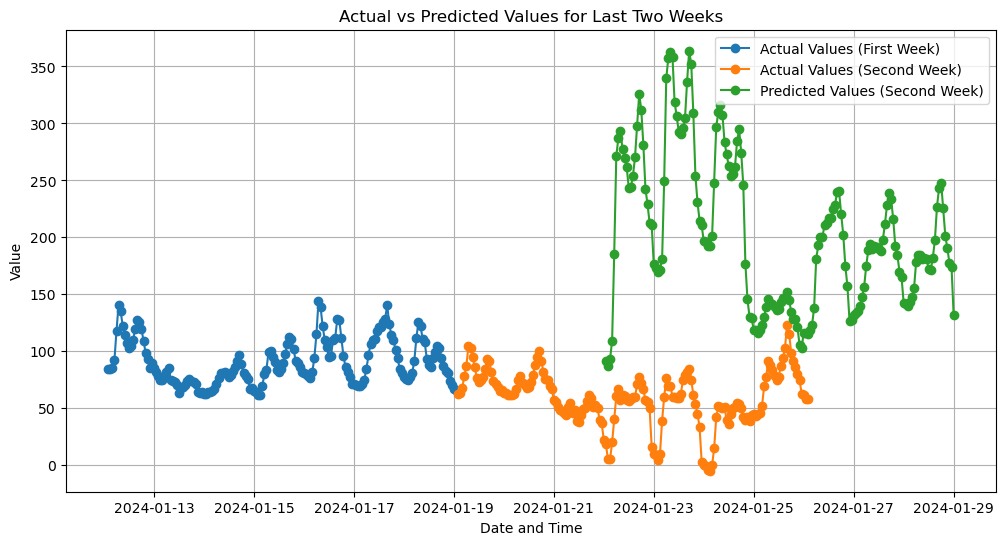

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


# Find the start timestamp for the last two weeks
last_timestamp = result.index[-1]
start_timestamp_last_two_weeks = last_timestamp - pd.Timedelta(weeks=2)

# Split the result DataFrame into two weeks
result_last_two_weeks = result.loc[result.index >= start_timestamp_last_two_weeks]

# Define the midpoint of the two-week period
midpoint_timestamp = start_timestamp_last_two_weeks + pd.Timedelta(weeks=1)

# Split the result DataFrame into two: first and second week
result_first_week = result_last_two_weeks.loc[result_last_two_weeks.index < midpoint_timestamp]
result_second_week = result_last_two_weeks.loc[result_last_two_weeks.index >= midpoint_timestamp]

# Plot actual values for the first week and actual vs predicted values for the second week
plt.figure(figsize=(12, 6))

# Plot actual values for the first week
plt.plot(result_first_week.index, result_first_week['_value'], label='Actual Values (First Week)', marker='o')

# Plot actual values for the second week
plt.plot(result_second_week.index, result_second_week['_value'], label='Actual Values (Second Week)', marker='o')

# Plot predicted values for the second week
plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values (Second Week)', marker='o')

plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values for Last Two Weeks')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
#Introducing Rolling Statistics for test data

In [13]:
# Rolling Statistics
window_sizes = [24]  # Window sizes for rolling statistics
for window in window_sizes:
    result_clipped[f'rolling_mean_{window}'] = result_clipped['_value'].rolling(window=window).mean()


result_clipped= result_clipped.iloc[24:]


result_clipped

,_value,hour,Month,Day,Day_of_week,rolling_mean_24
_time,,,,,,
2021-12-12 00:00:00,120.50,0,12,12,7,229.935000
2021-12-12 01:00:00,114.17,1,12,12,7,226.024167
2021-12-12 02:00:00,109.92,2,12,12,7,221.995833
2021-12-12 03:00:00,106.98,3,12,12,7,218.053333
2021-12-12 04:00:00,105.90,4,12,12,7,213.853333
...,...,...,...,...,...,...
2022-03-04 19:00:00,400.08,19,3,4,5,354.688750
2022-03-04 20:00:00,381.83,20,3,4,5,356.015000
2022-03-04 21:00:00,359.07,21,3,4,5,357.064583


In [14]:
# Calculate the date 1 year ago
one_year_ago_date = given_date_test - timedelta(days=730)

# Filter out all rows for the day exactly 1 year ago
one_year_ago_data = result_clipped[result_clipped.index.date == one_year_ago_date.date()]
one_year_ago_data

,_value,hour,Month,Day,Day_of_week,rolling_mean_24
_time,,,,,,
2022-01-22 00:00:00,120.30,0,1,22,6,159.553750
2022-01-22 01:00:00,119.99,1,1,22,6,159.931667
2022-01-22 02:00:00,121.80,2,1,22,6,160.292500
2022-01-22 03:00:00,123.57,3,1,22,6,160.476667
2022-01-22 04:00:00,123.68,4,1,22,6,160.599583
2022-01-22 05:00:00,120.00,5,1,22,6,159.401250
2022-01-22 06:00:00,148.35,6,1,22,6,156.932917
2022-01-22 07:00:00,186.00,7,1,22,6,155.385000
2022-01-22 08:00:00,207.46,8,1,22,6,155.037917


In [15]:
# Calculate the average '_value' for the last day
average_last_year_same_date = one_year_ago_data['_value'].mean()
average_last_year_same_date


177.76208333333332

In [16]:
# Create a new column 'rolling mean' and fill it with average_last_day for the first 24 entries
test_data['rolling_mean_24'] = 0  # Initialize the column with zeros
test_data.iloc[:24, test_data.columns.get_loc('rolling_mean_24')] = average_last_year_same_date
test_data

,hour,Month,Day,Day_of_week,rolling_mean_24
2024-01-22 01:00:00,1,1,22,1,177.762083
2024-01-22 02:00:00,2,1,22,1,177.762083
2024-01-22 03:00:00,3,1,22,1,177.762083
2024-01-22 04:00:00,4,1,22,1,177.762083
2024-01-22 05:00:00,5,1,22,1,177.762083
...,...,...,...,...,...
2024-01-28 20:00:00,20,1,28,7,0.000000
2024-01-28 21:00:00,21,1,28,7,0.000000
2024-01-28 22:00:00,22,1,28,7,0.000000
2024-01-28 23:00:00,23,1,28,7,0.000000


In [17]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Assuming 'result_clipped' is the training data DataFrame
# # Assuming '_value' is the target variable to be predicted

# # Features for training
# X_train = result_clipped[['hour', 'Month', 'Day', 'Day_of_week','rolling_mean_24']]
# y_train = result_clipped['_value']

# # Split training data into training and validation sets (optional)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


# # Initialize the Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Train the model on the training data
# rf_model.fit(X_train, y_train)

# # Predict on the validation set (optional)
# if 'X_val' in locals():
#     y_val_pred = rf_model.predict(X_val)
#     val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
#     print(f'Validation RMSE: {val_rmse}')
#     r2 = r2_score(y_val, y_val_pred)
#     print(f'Validation R2: {r2}')


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'result_clipped' is the training data DataFrame
# Assuming '_value' is the target variable to be predicted

# Features for training
X_train = result_clipped[['hour', 'Month', 'Day', 'Day_of_week','rolling_mean_24']]
y_train = result_clipped['_value']

# Split training data into training and validation sets (optional)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


# Features for test
X_test = test_data[['hour', 'Month', 'Day', 'Day_of_week','rolling_mean_24']]

# # Initialize the Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Train the model on the training data
# rf_model.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Train the model using Grid Search
grid_search.fit(X_train, y_train)

# Best hyperparameters found by Grid Search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize the Random Forest Regressor with the best hyperparameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)

# Train the model with the best hyperparameters on the entire training data
best_rf_model.fit(X_train, y_train)




# Predict on the validation set (optional)
if 'X_val' in locals():
#     y_val_pred = rf_model.predict(X_val)
    y_val_pred = best_rf_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f'Validation RMSE: {val_rmse}')
    r2 = r2_score(y_val, y_val_pred)
    print(f'Validation R2: {r2}')
    

# Predict on the test data
# y_test_pred = rf_model.predict(X_test)
y_test_pred = best_rf_model.predict(X_test)


# Create a new DataFrame for test results
test_results = X_test.copy()

# Add the predicted values to the DataFrame
test_results['_value_pred'] = y_test_pred
# test_results['_value_pred'] -= 40
test_results

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Validation RMSE: 27.950160613938934
Validation R2: 0.9264164610455184


,hour,Month,Day,Day_of_week,rolling_mean_24,_value_pred
2024-01-22 01:00:00,1,1,22,1,177.762083,181.6720
2024-01-22 02:00:00,2,1,22,1,177.762083,180.5244
2024-01-22 03:00:00,3,1,22,1,177.762083,183.3140
2024-01-22 04:00:00,4,1,22,1,177.762083,197.9390
2024-01-22 05:00:00,5,1,22,1,177.762083,263.1250
...,...,...,...,...,...,...
2024-01-28 20:00:00,20,1,28,7,0.000000,122.5810
2024-01-28 21:00:00,21,1,28,7,0.000000,122.2588
2024-01-28 22:00:00,22,1,28,7,0.000000,118.7564
2024-01-28 23:00:00,23,1,28,7,0.000000,106.8326


In [19]:
unique_days = test_data.index.floor('D').unique()
unique_days

DatetimeIndex(['2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25',
               '2024-01-26', '2024-01-27', '2024-01-28', '2024-01-29'],
              dtype='datetime64[ns]', freq=None)

In [20]:
# # Create a new DataFrame for test results
# y_test_pred_whole=[]

# for day in unique_days:
#     # Select data for the current day
#     day_data = test_data[pd.to_datetime(test_data.index.date) == day]
    
#     # Predict on the test data
#     y_test_pred = rf_model.predict(day_data)
    
    
#     predicted_rolling_mean = np.mean(y_test_pred)
#     print(predicted_rolling_mean)
    
#     next_day = day + pd.Timedelta(days=1)
    
#     test_data.loc[test_data.index.date == next_day.date(), 'rolling_mean_24'] = predicted_rolling_mean
    
#     y_test_pred_whole.extend(y_test_pred)

    
# test_results = test_data.copy()
   
# test_results['_value_pred'] = y_test_pred_whole  
# test_results['_value_pred'] -= 40
# test_results  

In [21]:
# Create a new DataFrame for test results
y_test_pred_whole=[]

for day in unique_days:
    # Select data for the current day
    day_data = test_data[pd.to_datetime(test_data.index.date) == day]
    
    # Predict on the test data
    y_test_pred = best_rf_model.predict(day_data)
    
    
    predicted_rolling_mean = np.mean(y_test_pred)
    print(predicted_rolling_mean)
    
    next_day = day + pd.Timedelta(days=1)
    
    test_data.loc[test_data.index.date == next_day.date(), 'rolling_mean_24'] = predicted_rolling_mean
    
    y_test_pred_whole.extend(y_test_pred)

    
test_results = test_data.copy()
   
test_results['_value_pred'] = y_test_pred_whole 
# test_results['_value_pred'] -= 40
test_results  

259.00312173913056
279.0113416666666
264.8029333333333
236.67780000000005
161.3553333333333
155.95834166666668
139.55106666666666
85.3988


,hour,Month,Day,Day_of_week,rolling_mean_24,_value_pred
2024-01-22 01:00:00,1,1,22,1,177.762083,181.6720
2024-01-22 02:00:00,2,1,22,1,177.762083,180.5244
2024-01-22 03:00:00,3,1,22,1,177.762083,183.3140
2024-01-22 04:00:00,4,1,22,1,177.762083,197.9390
2024-01-22 05:00:00,5,1,22,1,177.762083,263.1250
...,...,...,...,...,...,...
2024-01-28 20:00:00,20,1,28,7,155.958342,141.4662
2024-01-28 21:00:00,21,1,28,7,155.958342,134.9294
2024-01-28 22:00:00,22,1,28,7,155.958342,119.3434
2024-01-28 23:00:00,23,1,28,7,155.958342,117.3060


In [22]:
# test_results.to_csv('result2.2.1.csv', index=True)

In [23]:
# # Fetch actual values for the days/hours corresponding to predictions
# actual_values = result.loc[test_results.index, '_value']

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(actual_values.index, actual_values, label='Actual Values', marker='o')
# plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values', marker='o')
# plt.xlabel('Date and Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.show()

In [24]:
# mae_rf = mean_absolute_error(actual_values, test_results['_value_pred'])
# rmse_rf = np.sqrt(mean_squared_error(actual_values, test_results['_value_pred']))
# print(f'MAE (Random Forest): {mae_rf:.2f}')
# print(f'RMSE (Random Forest): {rmse_rf:.2f}')


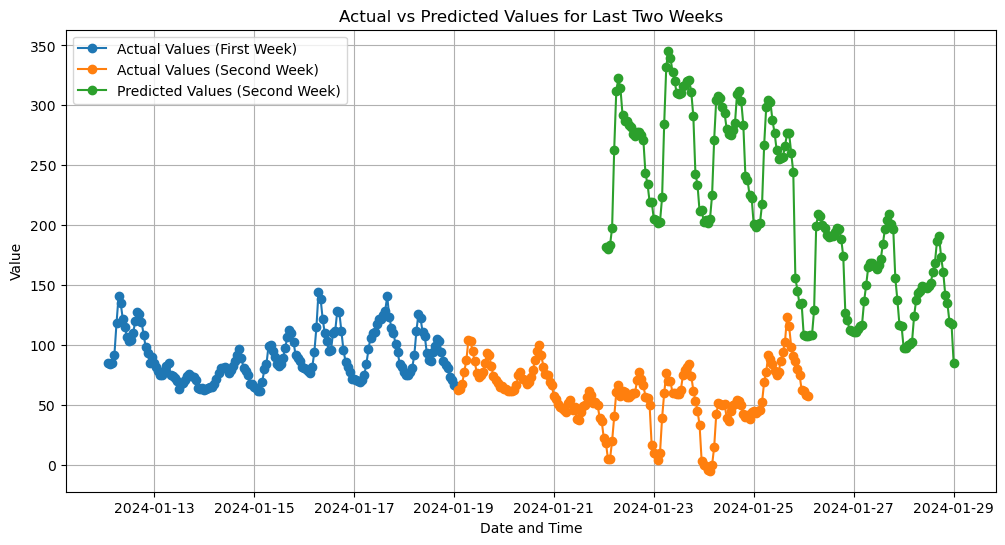

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


# Find the start timestamp for the last two weeks
last_timestamp = result.index[-1]
start_timestamp_last_two_weeks = last_timestamp - pd.Timedelta(weeks=2)

# Split the result DataFrame into two weeks
result_last_two_weeks = result.loc[result.index >= start_timestamp_last_two_weeks]

# Define the midpoint of the two-week period
midpoint_timestamp = start_timestamp_last_two_weeks + pd.Timedelta(weeks=1)

# Split the result DataFrame into two: first and second week
result_first_week = result_last_two_weeks.loc[result_last_two_weeks.index < midpoint_timestamp]
result_second_week = result_last_two_weeks.loc[result_last_two_weeks.index >= midpoint_timestamp]

# Plot actual values for the first week and actual vs predicted values for the second week
plt.figure(figsize=(12, 6))

# Plot actual values for the first week
plt.plot(result_first_week.index, result_first_week['_value'], label='Actual Values (First Week)', marker='o')

# Plot actual values for the second week
plt.plot(result_second_week.index, result_second_week['_value'], label='Actual Values (Second Week)', marker='o')

# Plot predicted values for the second week
plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values (Second Week)', marker='o')

plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values for Last Two Weeks')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
#rolling mean of last day before test date start

#24 hours rolling mean

# Calculate the date 1 year ago
one_day_ago_date = given_date_test - timedelta(days=1)

# Filter out all rows for the day exactly 1 year ago
one_day_ago_data = result[result.index.date == one_day_ago_date.date()]
one_day_ago_data


,_value
_time,
2024-01-21 00:00:00,57.55
2024-01-21 01:00:00,55.15
2024-01-21 02:00:00,50.89
2024-01-21 03:00:00,48.51
2024-01-21 04:00:00,47.45
2024-01-21 05:00:00,45.53
2024-01-21 06:00:00,43.96
2024-01-21 07:00:00,51.36
2024-01-21 08:00:00,54.36


In [27]:
# Calculate the average '_value' for the last day
average_last_day = one_day_ago_data['_value'].mean()
average_last_day


49.001666666666665

In [28]:
# Specify the number of hours for prediction
num_hours_for_prediction = 7 * 24

test_start=given_date_test 

# Create a new DataFrame for the test data
# test_data = pd.DataFrame(index=pd.date_range(start=result_clipped.index[-1] + timedelta(hours=1), periods=num_hours_for_prediction, freq='H'))
test_data = pd.DataFrame(index=pd.date_range(start=test_start + timedelta(hours=1), periods=num_hours_for_prediction, freq='H'))



# Extract features for the next 7 days
test_data['hour'] = test_data.index.hour
test_data['Month'] = test_data.index.month
test_data['Day'] = test_data.index.day


test_data['Day_of_week'] = test_data.index.dayofweek + 1

# Create a new column 'rolling mean' and fill it with average_last_day for the first 24 entries
test_data['rolling_mean_24'] = 0  # Initialize the column with zeros
test_data.iloc[:24, test_data.columns.get_loc('rolling_mean_24')] = average_last_day

# Fill NaN values with 0 (if needed)
test_data = test_data.fillna(0)
test_data

,hour,Month,Day,Day_of_week,rolling_mean_24
2024-01-22 01:00:00,1,1,22,1,49.001667
2024-01-22 02:00:00,2,1,22,1,49.001667
2024-01-22 03:00:00,3,1,22,1,49.001667
2024-01-22 04:00:00,4,1,22,1,49.001667
2024-01-22 05:00:00,5,1,22,1,49.001667
...,...,...,...,...,...
2024-01-28 20:00:00,20,1,28,7,0.000000
2024-01-28 21:00:00,21,1,28,7,0.000000
2024-01-28 22:00:00,22,1,28,7,0.000000
2024-01-28 23:00:00,23,1,28,7,0.000000


In [29]:
unique_days = test_data.index.floor('D').unique()
unique_days

DatetimeIndex(['2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25',
               '2024-01-26', '2024-01-27', '2024-01-28', '2024-01-29'],
              dtype='datetime64[ns]', freq=None)

In [30]:
# Create a new DataFrame for test results
y_test_pred_whole=[]

for day in unique_days:
    # Select data for the current day
    day_data = test_data[pd.to_datetime(test_data.index.date) == day]
    
    # Predict on the test data
    y_test_pred = best_rf_model.predict(day_data)
    
    
    predicted_rolling_mean = np.mean(y_test_pred)
    print(predicted_rolling_mean)
    
    next_day = day + pd.Timedelta(days=1)
    
    test_data.loc[test_data.index.date == next_day.date(), 'rolling_mean_24'] = predicted_rolling_mean
    
    y_test_pred_whole.extend(y_test_pred)

    
test_results = test_data.copy()
   
test_results['_value_pred'] = y_test_pred_whole 
# test_results['_value_pred'] -= 40
test_results  

89.32132173913043
121.63148333333334
125.05080185185183
126.4890638888889
164.5245861111111
163.591575
151.587975
78.98599999999999


,hour,Month,Day,Day_of_week,rolling_mean_24,_value_pred
2024-01-22 01:00:00,1,1,22,1,49.001667,23.9060
2024-01-22 02:00:00,2,1,22,1,49.001667,24.2534
2024-01-22 03:00:00,3,1,22,1,49.001667,25.5960
2024-01-22 04:00:00,4,1,22,1,49.001667,34.8680
2024-01-22 05:00:00,5,1,22,1,49.001667,39.3308
...,...,...,...,...,...,...
2024-01-28 20:00:00,20,1,28,7,163.591575,171.7246
2024-01-28 21:00:00,21,1,28,7,163.591575,159.3768
2024-01-28 22:00:00,22,1,28,7,163.591575,131.6794
2024-01-28 23:00:00,23,1,28,7,163.591575,129.7570


In [31]:
# test_results.to_csv('result2.2.2.csv', index=True)

In [32]:
# # Fetch actual values for the days/hours corresponding to predictions
# actual_values = result.loc[test_results.index, '_value']

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(actual_values.index, actual_values, label='Actual Values', marker='o')
# plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values', marker='o')
# plt.xlabel('Date and Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.show()

In [33]:
# mae_rf = mean_absolute_error(actual_values, test_results['_value_pred'])
# rmse_rf = np.sqrt(mean_squared_error(actual_values, test_results['_value_pred']))
# print(f'MAE (Random Forest): {mae_rf:.2f}')
# print(f'RMSE (Random Forest): {rmse_rf:.2f}')


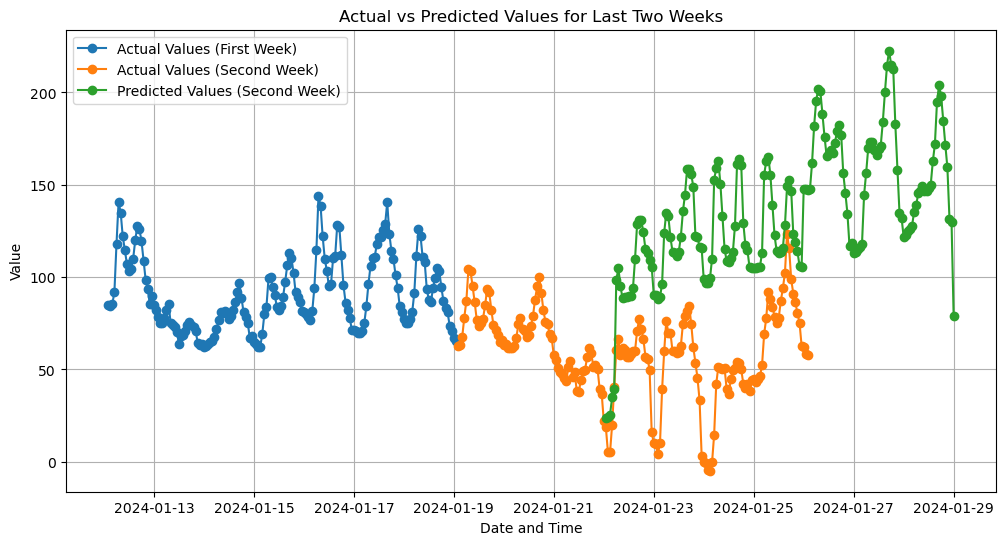

In [34]:
import pandas as pd
import matplotlib.pyplot as plt


# Find the start timestamp for the last two weeks
last_timestamp = result.index[-1]
start_timestamp_last_two_weeks = last_timestamp - pd.Timedelta(weeks=2)

# Split the result DataFrame into two weeks
result_last_two_weeks = result.loc[result.index >= start_timestamp_last_two_weeks]

# Define the midpoint of the two-week period
midpoint_timestamp = start_timestamp_last_two_weeks + pd.Timedelta(weeks=1)

# Split the result DataFrame into two: first and second week
result_first_week = result_last_two_weeks.loc[result_last_two_weeks.index < midpoint_timestamp]
result_second_week = result_last_two_weeks.loc[result_last_two_weeks.index >= midpoint_timestamp]

# Plot actual values for the first week and actual vs predicted values for the second week
plt.figure(figsize=(12, 6))

# Plot actual values for the first week
plt.plot(result_first_week.index, result_first_week['_value'], label='Actual Values (First Week)', marker='o')

# Plot actual values for the second week
plt.plot(result_second_week.index, result_second_week['_value'], label='Actual Values (Second Week)', marker='o')

# Plot predicted values for the second week
plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values (Second Week)', marker='o')

plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values for Last Two Weeks')
plt.legend()
plt.grid(True)
plt.show()
